In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping  # Importer EarlyStopping
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from functions import *
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer


### 1-Préparation des données

#### &nbsp;&nbsp;a) Merger les datas en un seul dataframe

In [53]:
df = pd.concat([pd.read_csv("source_data/goemotions_1.csv"),pd.read_csv("source_data/goemotions_2.csv"),pd.read_csv("source_data/goemotions_3.csv")],ignore_index=True)
df.describe()
df=df.drop(columns=['created_utc','rater_id'])

#### &nbsp;&nbsp;b) Afficher la repartition des emotions présentes dans notre dataset

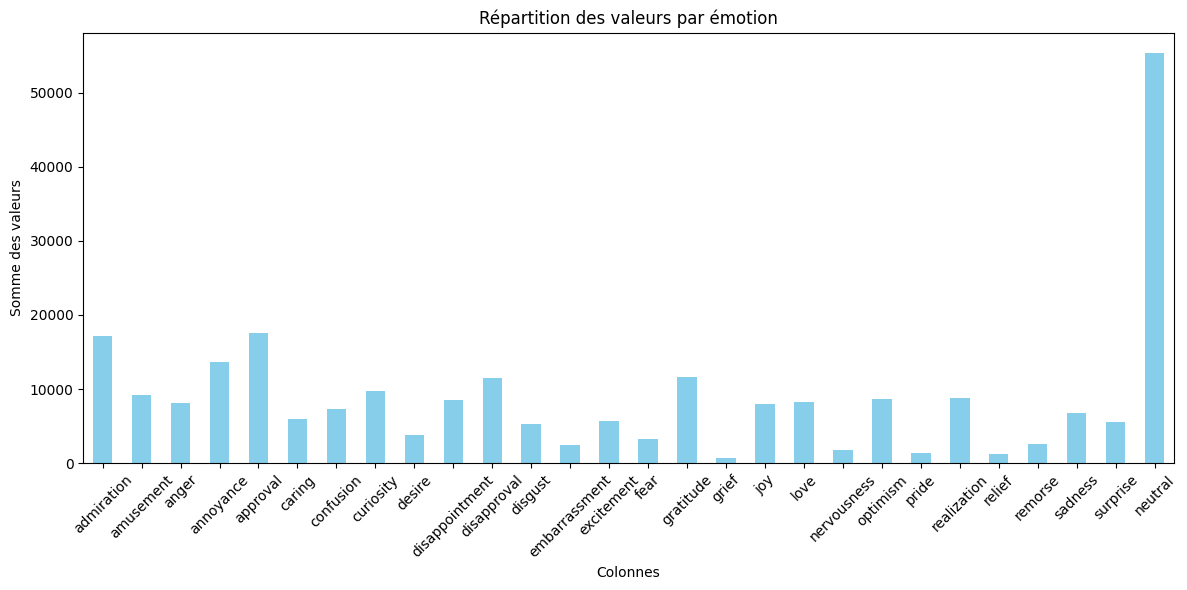

In [54]:
numeric_columns = df.select_dtypes(include=['number']).columns
# Calculer la somme de chaque colonne numérique
sum_values = df[numeric_columns].sum()

# Créer un graphique avec une barre par colonne
plt.figure(figsize=(12, 6))
sum_values.plot(kind='bar', color='skyblue')

# Ajouter des labels et un titre
plt.title('Répartition des valeurs par émotion')
plt.xlabel('Colonnes')
plt.ylabel('Somme des valeurs')

# Afficher les labels des colonnes sur l'axe x
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()

#### &nbsp;&nbsp;c) ajoutons plus de données

In [55]:
#ajout du second jeu d'emotion en mode onehot
df2=pd.read_csv("source_data/more_emotions.csv",sep=";")
df2.dropna()
dfmore=pd.get_dummies(df2["emotion"], dtype=int)
dfmore['text']=df2['text']



#### &nbsp;&nbsp;d) Visualiser l'apport du second jeu de données (en rouge)

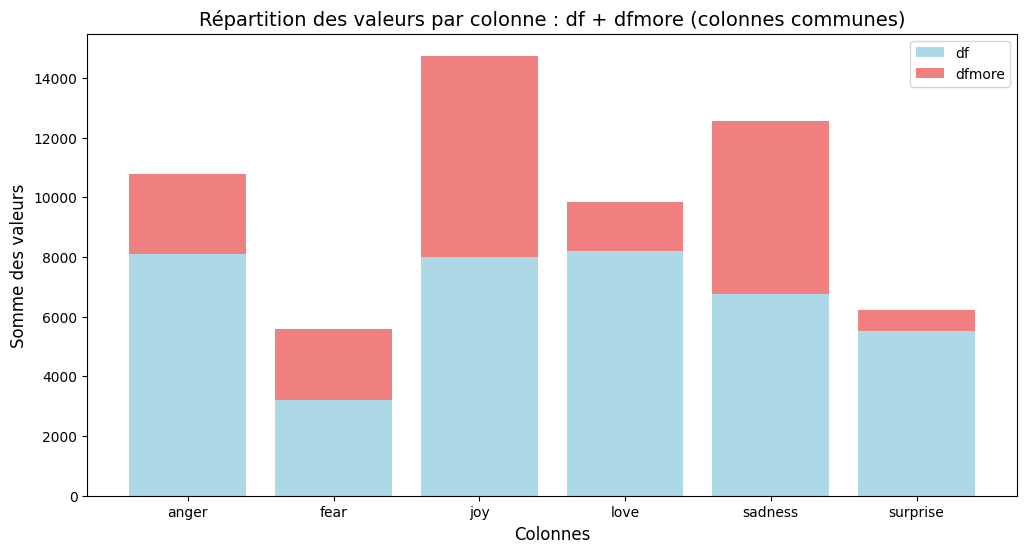

In [56]:
#Sélectionner les colonnes numériques communes aux deux DataFrames
common_columns = df.select_dtypes(include=['number']).columns.intersection(dfmore.select_dtypes(include=['number']).columns)

# Calculer la somme de chaque colonne dans df et dfmore pour les colonnes communes
df_sum = df[common_columns].sum()
dfmore_sum = dfmore[common_columns].sum()

# Créer un graphique empilé
plt.figure(figsize=(12, 6))

# Tracer les barres empilées : df (en bleu pastel) et dfmore (en rouge pastel)
plt.bar(common_columns, df_sum, color='lightblue', label='df')
plt.bar(common_columns, dfmore_sum, color='lightcoral', bottom=df_sum, label='dfmore')

# Ajouter des labels et un titre
plt.title('Répartition des valeurs par colonne : df + dfmore (colonnes communes)', fontsize=14)
plt.xlabel('Colonnes', fontsize=12)
plt.ylabel('Somme des valeurs', fontsize=12)

# Ajouter une légende
plt.legend()

#il n'y a pas de neutral dans le jeu de données complémentaires

In [57]:
df = pd.concat([df,dfmore])

In [58]:
df.describe()

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
count,211225.000000,211225.000000,231225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,...,231225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,231225.000000,231225.000000,211225.000000
mean,0.081103,0.043768,0.046677,0.064472,0.083418,0.028401,0.034840,0.045885,0.018071,0.040095,...,0.042521,0.008569,0.041259,0.006164,0.041591,0.006102,0.011954,0.054298,0.026956,0.261797
std,0.272994,0.204580,0.210948,0.245592,0.276514,0.166116,0.183374,0.209236,0.133208,0.196182,...,0.201776,0.092172,0.198890,0.078269,0.199653,0.077880,0.108679,0.226605,0.161956,0.439614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
df.tail()

,text,id,author,subreddit,link_id,parent_id,example_very_unclear,admiration,amusement,anger,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
19995,im having ssa examination tomorrow in the morn...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
19996,i constantly worry about their fight against n...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
19997,i feel its important to share this info for th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
19998,i truly feel that if you are passionate enough...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
19999,i feel like i just wanna buy any cute make up ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


#### &nbsp;&nbsp;e) Supprimer les doublons et réduire aux 5 emotions principales (+ neutral)

In [60]:
#supprimer les doublons
df.describe()
df= df.drop_duplicates(subset='text', keep='first')
df.describe()

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
count,57732.000000,57732.000000,77680.000000,57732.000000,57732.000000,57732.000000,57732.000000,57732.000000,57732.000000,57732.000000,...,77680.000000,57732.000000,57732.000000,57732.000000,57732.000000,57732.000000,57732.000000,77680.000000,77680.000000,57732.000000
mean,0.083766,0.045729,0.063285,0.060123,0.083801,0.027472,0.034539,0.047980,0.017547,0.037536,...,0.051197,0.008262,0.042056,0.006062,0.040861,0.006357,0.012281,0.098185,0.028489,0.267962
std,0.277040,0.208898,0.243477,0.237716,0.277092,0.163455,0.182610,0.213726,0.131297,0.190072,...,0.220401,0.090522,0.200720,0.077626,0.197970,0.079477,0.110138,0.297566,0.166365,0.442902
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:

#ne sortir que les 5 emotions + neutral
#anger, fear, joy, sadness, surprise, neutral et remplir les NAN par des 0
valid_fields = ['text','anger', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
df_filtered = df[valid_fields]
df_filtered["neutral"]=df_filtered["neutral"].fillna(0)
df_filtered["neutral"] = df_filtered["neutral"].astype(int)

df_filtered = df_filtered[df_filtered.drop('text', axis=1).sum(axis=1) > 0]
df_filtered.tail()

/tmp/ipykernel_1437/1346029709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["neutral"]=df_filtered["neutral"].fillna(0)
/tmp/ipykernel_1437/1346029709.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["neutral"] = df_filtered["neutral"].astype(int)


,text,anger,fear,joy,sadness,surprise,neutral
19995,im having ssa examination tomorrow in the morn...,0,0,0,1,0,0
19996,i constantly worry about their fight against n...,0,0,1,0,0,0
19997,i feel its important to share this info for th...,0,0,1,0,0,0
19998,i truly feel that if you are passionate enough...,0,0,1,0,0,0
19999,i feel like i just wanna buy any cute make up ...,0,0,1,0,0,0


In [62]:
#counts
sums=df_filtered.select_dtypes(include=['number']).sum().apply(int)
sums

anger        4916
fear         3249
joy          8928
sadness      7627
surprise     2213
neutral     15470
dtype: int64

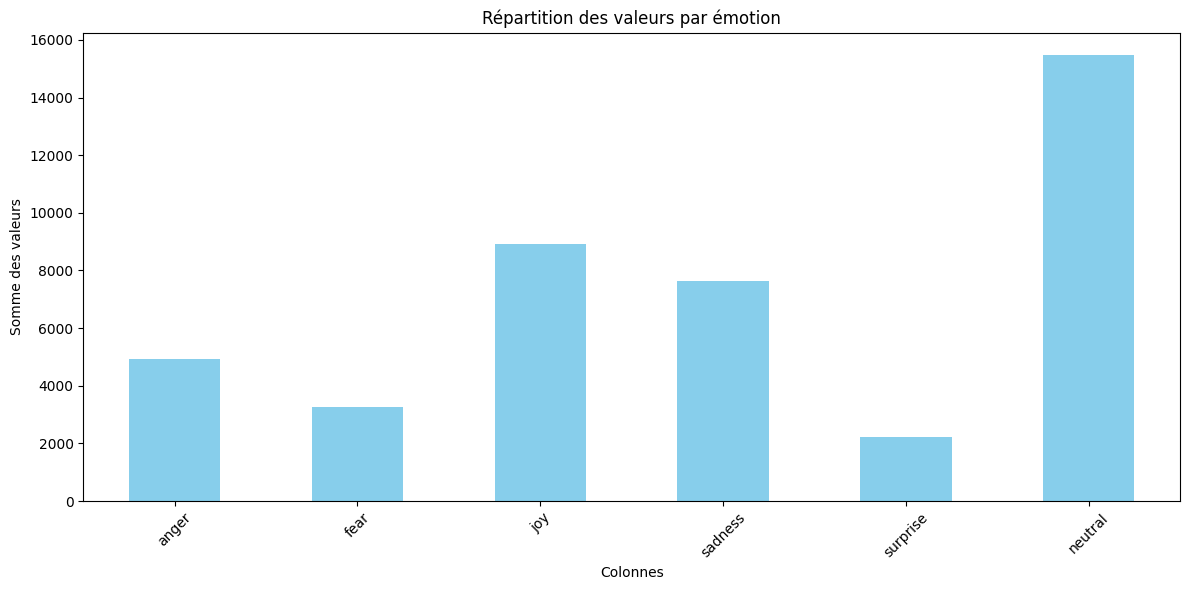

In [63]:
numeric_columns = df_filtered.select_dtypes(include=['number']).columns
# Calculer la somme de chaque colonne numérique
sum_values = df_filtered[numeric_columns].sum()

# Créer un graphique avec une barre par colonne
plt.figure(figsize=(12, 6))
sum_values.plot(kind='bar', color='skyblue')

# Ajouter des labels et un titre
plt.title('Répartition des valeurs par émotion')
plt.xlabel('Colonnes')
plt.ylabel('Somme des valeurs')

# Afficher les labels des colonnes sur l'axe x
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()

#### &nbsp;&nbsp;f) Il y a trop de neutral, les classes sont plutot déséquilibrés, on va ecreter de manière aléatoire

In [64]:
#sortir une colonne emotion pour un reechantillonage efficace

emotion_columns =df_filtered.select_dtypes(include=['int64', 'int32', 'int16', 'int8']).columns

def get_single_emotion(row):
    # On retourne l'émotion où la valeur est 1
    for emotion in emotion_columns:
        if row[emotion] == 1:
            return emotion
    return None  # Au cas où aucune émotion n'est présente (valeur par défaut)

df_filtered['emotion'] = df_filtered.apply(get_single_emotion, axis=1)

df_filtered

,text,anger,fear,joy,sadness,surprise,neutral,emotion
0,That game hurt.,0,0,0,1,0,0,sadness
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,1,neutral
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,1,neutral
10,"I have, and now that you mention it, I think t...",0,0,0,0,0,1,neutral
12,BUT IT'S HER TURN! /s,0,0,0,0,0,1,neutral
...,...,...,...,...,...,...,...,...
19995,im having ssa examination tomorrow in the morn...,0,0,0,1,0,0,sadness
19996,i constantly worry about their fight against n...,0,0,1,0,0,0,joy
19997,i feel its important to share this info for th...,0,0,1,0,0,0,joy
19998,i truly feel that if you are passionate enough...,0,0,1,0,0,0,joy


In [65]:
# Définir la taille cible pour chaque classe
target_size = 6000

# Rééchantillonner chaque classe sans ajouter de nouvelles entrées
balanced_df = df_filtered.groupby('emotion').apply(
    lambda x: x.sample(n=target_size, random_state=42) if len(x) > target_size else x
).reset_index(drop=True)

# Vérifier la distribution des classes après rééquilibrage
print(balanced_df['emotion'].value_counts())

emotion
neutral     6000
joy         6000
sadness     6000
anger       4916
fear        3231
surprise    2126
Name: count, dtype: int64


In [66]:

#on melange un bon coup
df_filtered = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


#### &nbsp;&nbsp;g) On lematize, tokenise, nettoie

In [67]:
#on nettoie sur le dernier echantillon
tqdm.pandas()

#tokenisation pour ltsm du coup echantillon réduit = spacy plus rapide
df=nettoyer_texte(df_filtered,"text")

df.head()

Nettoyage et tokenisation des messages:   0%|          | 0/28273 [00:00<?, ?it/s]

Nettoyage et tokenisation des messages: 100%|██████████| 28273/28273 [02:46<00:00, 169.60it/s]


,text,anger,fear,joy,sadness,surprise,neutral,emotion
0,feel like weird sugar issue hunger place,0,0,0,0,1,0,surprise
1,feel physically sort ache kind expect response...,0,0,0,1,0,0,sadness
2,push hey dumbass push emergency button,1,0,0,0,0,0,anger
3,tired feel lethargic,0,0,0,1,0,0,sadness
4,feel suck mad sad,1,0,0,0,0,0,anger


#### &nbsp;&nbsp;h) Visualisons les nuages de mots

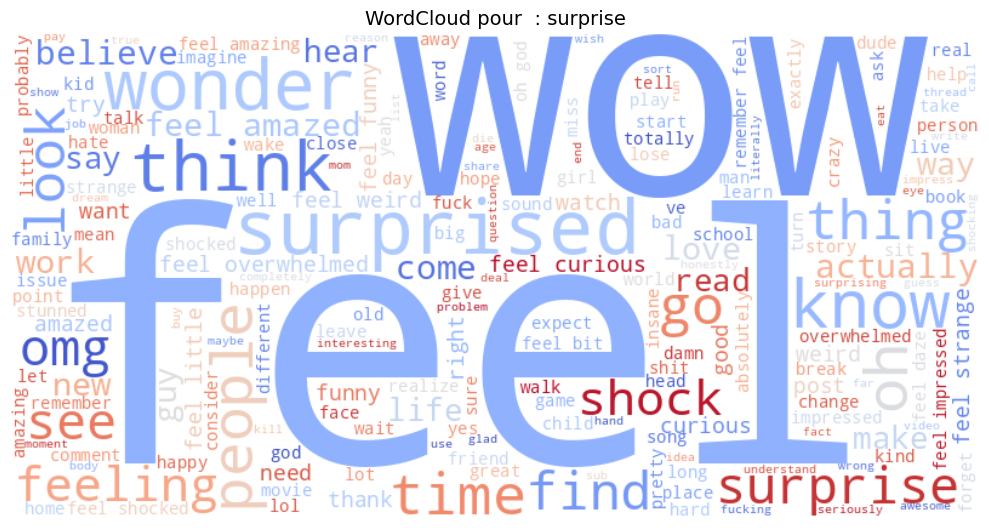

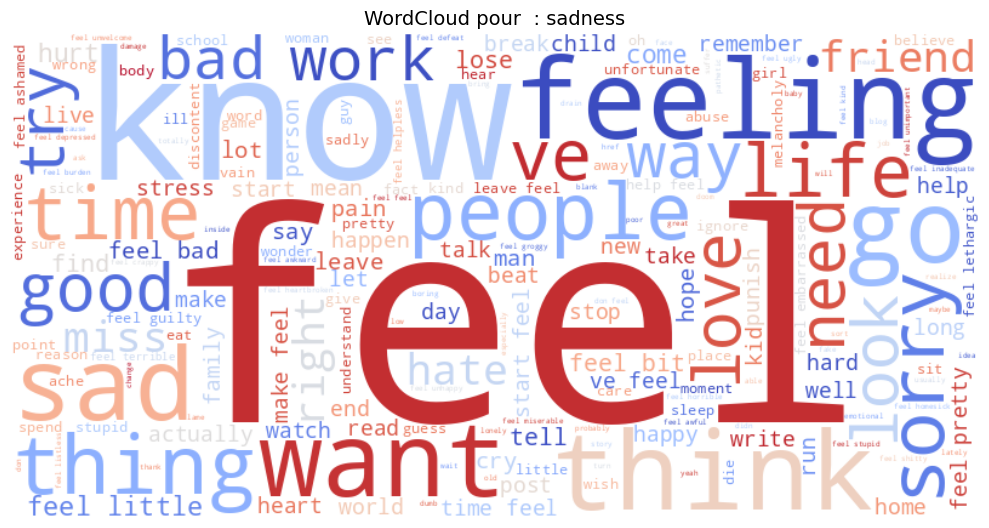

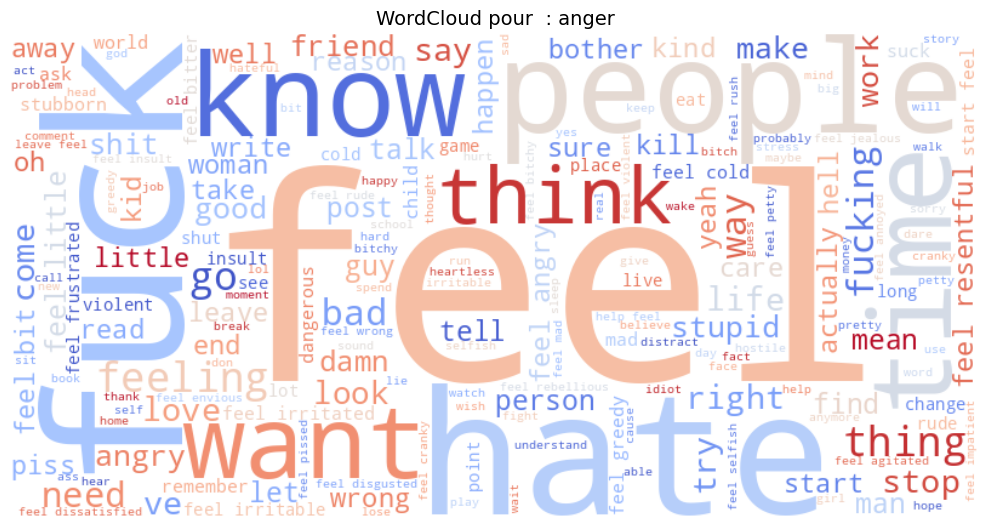

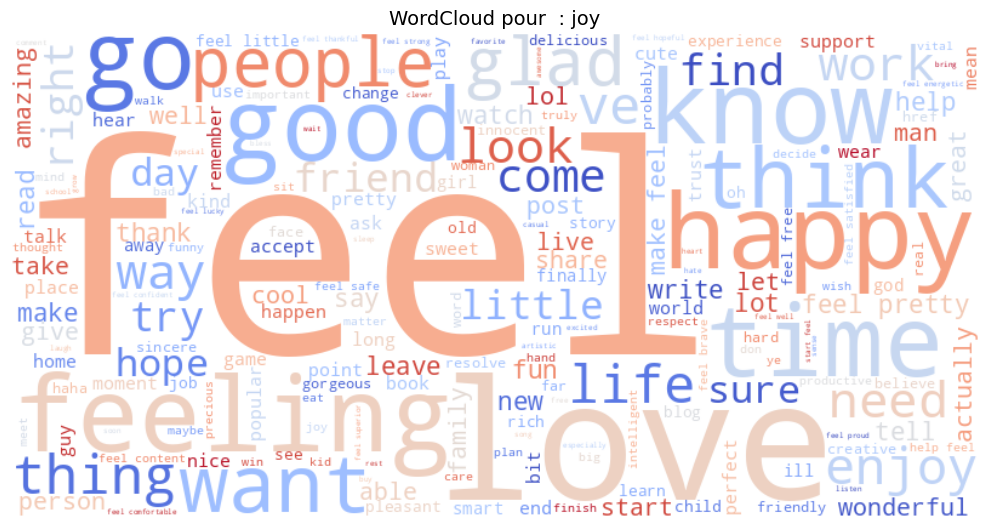

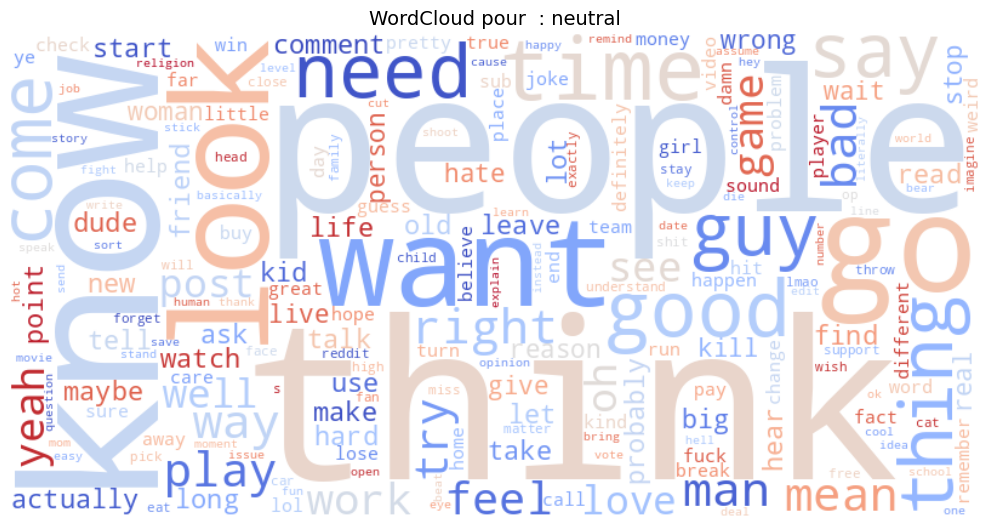

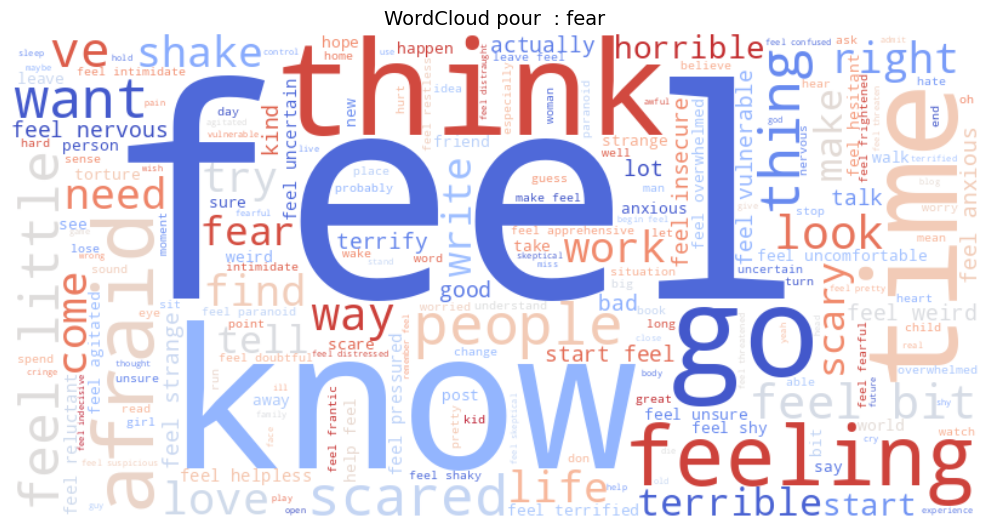

In [68]:
emotions = df_filtered['emotion'].unique()

# Créer un WordCloud pour chaque émotion
for emotion in emotions:
    #pour chaque text du dataframe ou la colonne emotion = 1
    texts = df_filtered[df_filtered[emotion] == 1]['text']
    
    # Joindre tous les textes en une seule chaîne de caractères
    text_for_wordcloud = ' '.join(texts)
    
    # Créer le WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate(text_for_wordcloud)
    
    # Afficher le WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Ne pas afficher les axes
    plt.title(f"WordCloud pour  : {emotion}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [69]:
df

,text,anger,fear,joy,sadness,surprise,neutral,emotion
0,feel like weird sugar issue hunger place,0,0,0,0,1,0,surprise
1,feel physically sort ache kind expect response...,0,0,0,1,0,0,sadness
2,push hey dumbass push emergency button,1,0,0,0,0,0,anger
3,tired feel lethargic,0,0,0,1,0,0,sadness
4,feel suck mad sad,1,0,0,0,0,0,anger
...,...,...,...,...,...,...,...,...
28268,ve come point feel submissive self task handle,0,0,0,1,0,0,sadness
28269,come hypothetical question get to feel scary,0,1,0,0,0,0,fear
28270,disrespectful like cheater make ridiculous exc...,1,0,0,0,0,0,anger
28271,smut target make cringe clearly politically ch...,0,0,0,0,0,1,neutral


#### &nbsp;&nbsp;i) Analyse en composantes principales

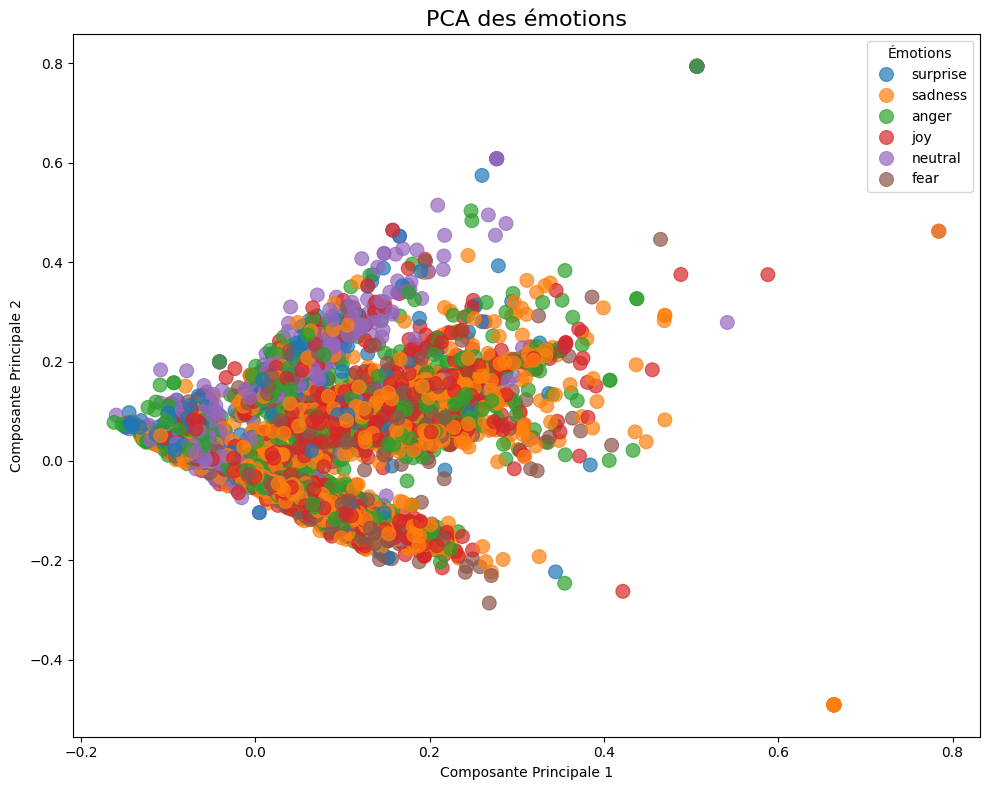

In [70]:
df_pca=df_filtered.copy()

# 1. Vectorisation des textes avec TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) 
X_tfidf = vectorizer.fit_transform(df_pca['text'])

# 2. Appliquer PCA pour réduire la dimensionnalité
pca = PCA(n_components=2)  # Réduction à 2 dimensions pour la visualisation
X_pca = pca.fit_transform(X_tfidf.toarray())  

# 3. Ajouter les résultats PCA au dataframe pour l'affichage
df_pca['pca1'] = X_pca[:, 0]  
df_pca['pca2'] = X_pca[:, 1]  

# 4. Visualisation des résultats de la PCA
plt.figure(figsize=(10, 8))

# Utilisation de seaborn pour afficher les points en fonction de l'émotion
sns.scatterplot(x='pca1', y='pca2', hue='emotion', data=df_pca, palette='tab10', s=100, alpha=0.7, edgecolor=None)

# Ajouter un titre et des labels
plt.title('PCA des émotions', fontsize=16)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Émotions')
plt.tight_layout()

plt.show()


In [71]:
df=df.dropna(subset=['text'])
df=df.drop(columns=['emotion'])
df = df[df.drop('text', axis=1).sum(axis=1) > 0]
df.head()

,text,anger,fear,joy,sadness,surprise,neutral
0,feel like weird sugar issue hunger place,0,0,0,0,1,0
1,feel physically sort ache kind expect response...,0,0,0,1,0,0
2,push hey dumbass push emergency button,1,0,0,0,0,0
3,tired feel lethargic,0,0,0,1,0,0
4,feel suck mad sad,1,0,0,0,0,0


### 2) Entrainement du modele

#### &nbsp;&nbsp;a) preparation de X et y, séparation du jeu d'entrainement, validation et test et tokenisation

In [72]:
X=df['text']
y=df.drop(columns=['text'])

In [73]:
max_words = 5000  # Nombre de mots maximum à utiliser dans le Tokenizer
max_len = 50  # Longueur maximale des séquences (nombres de mots conservés)
num_classes = 6  # Nombre d'émotions

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

tokenizer = Tokenizer(num_words=max_words)#le tokenizer de keras
#fit_on_texts: word_index["the"] = 1; word_index["cat"] = 2 word -> index dictionary (chaque mot recoit un index unique) : plus l'index est petit plus le mot est présent
tokenizer.fit_on_texts(X)
#texts_to_sequences: transforme chaque texte du mot dans sa sequence de chiffres provenant du word index
X_train= tokenizer.texts_to_sequences(X_train) # rend toutes les sequences de la meme longueur en mettant des zeros
X_train = pad_sequences(X_train, maxlen=max_len)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_test= tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_val= tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=max_len)

#### &nbsp;&nbsp;b) création du réseau de neurones LTSM

In [75]:

# Créer le modèle
def create_model(input_length=max_len, num_classes=6):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128))
    model.add(Dropout(0.6))
    model.add(Bidirectional(LSTM(80,return_sequences=True)))
    model.add(Bidirectional(LSTM(160)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))  # Sigmoid pour la classification multi-label
    model.add(Dropout(0.2))
    model.compile(loss='categorical_crossentropy',  optimizer=Adam(learning_rate=1e-4), metrics=['categorical_accuracy'])
    return model

    
model = create_model(input_length=max_len, num_classes=num_classes)

In [76]:
model.build((None, max_len))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 160)        │       133,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 320)            │       410,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,926 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,186,566 (4.53 MB)

 Trainable params: 1,186,566 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

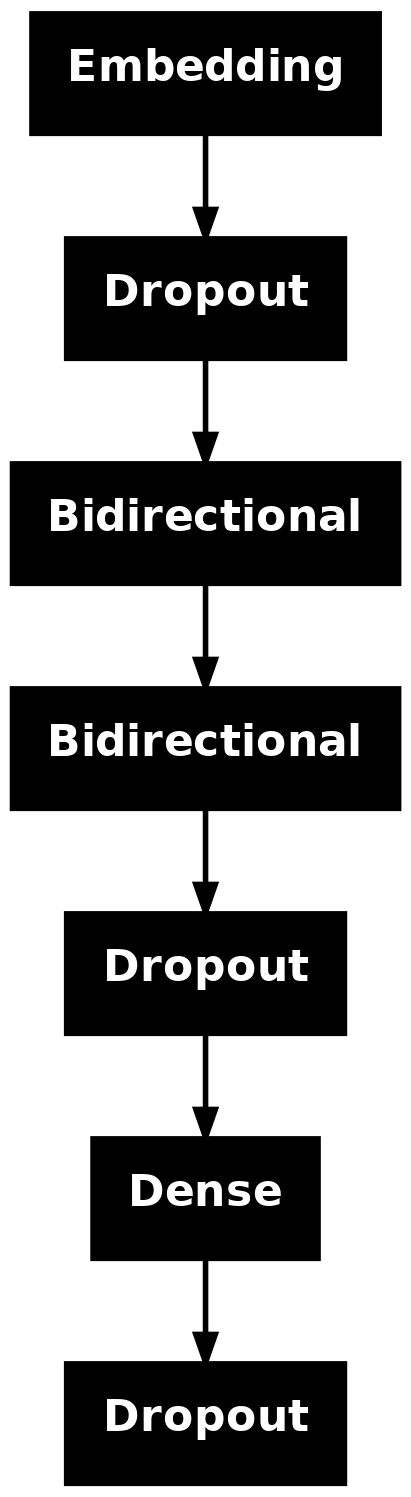

In [77]:
tf.keras.utils.plot_model(model)

#### &nbsp;&nbsp;c) entrainement

In [78]:
save_best_model=ModelCheckpoint(filepath='models/06.keras', monitor='val_categorical_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test),callbacks=[es,save_best_model])

Epoch 1/15


796/796 ━━━━━━━━━━━━━━━━━━━━ 64s 76ms/step - categorical_accuracy: 0.2498 - loss: nan - val_categorical_accuracy: 0.3812 - val_loss: 1.5121
Epoch 2/15
796/796 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - categorical_accuracy: 0.3559 - loss: nan - val_categorical_accuracy: 0.4395 - val_loss: 1.4623
Epoch 3/15
796/796 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - categorical_accuracy: 0.3928 - loss: nan - val_categorical_accuracy: 0.4979 - val_loss: 1.3667
Epoch 4/15
796/796 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - categorical_accuracy: 0.4429 - loss: 4.1820 - val_categorical_accuracy: 0.6075 - val_loss: 1.1385
Epoch 5/15
796/796 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - categorical_accuracy: 0.5299 - loss: 3.9681 - val_categorical_accuracy: 0.6658 - val_loss: 0.9708
Epoch 6/15
796/796 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - categorical_accuracy: 0.5685 - loss: nan - val_categorical_accuracy: 0.7203 - val_loss: 0.8633
Epoch 7/15
796/796 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - categorical_accuracy: 0.5894 - loss: 3.9149

In [79]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - categorical_accuracy: 0.6875 - loss: 0.9889

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - categorical_accuracy: 0.7790 - loss: 0.6861
Test Loss: 0.6792349815368652
Test Accuracy: 0.7751060724258423


#### &nbsp;&nbsp;d) prédiction sur data test

In [80]:
# Prédictions sur les données de test
predictions = model.predict(X_test)

# Convertir les probabilités en classes (émotions) en prenant l'index avec la probabilité la plus élevée
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test.values, axis=1)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


#### &nbsp;&nbsp;e) résultats


Rapport de Classification :
              precision    recall  f1-score   support

       anger       0.79      0.72      0.75       504
        fear       0.86      0.75      0.80       332
         joy       0.87      0.84      0.86       594
     sadness       0.81      0.81      0.81       599
    surprise       0.69      0.59      0.64       205
     neutral       0.65      0.80      0.72       594

    accuracy                           0.78      2828
   macro avg       0.78      0.75      0.76      2828
weighted avg       0.78      0.78      0.78      2828

AUC Scores:
{'anger': 0.9482897576701363, 'fear': 0.9625051637121252, 'joy': 0.970578827142142, 'sadness': 0.9504520746325005, 'surprise': 0.9197228475136141, 'neutral': 0.9270796596221843}


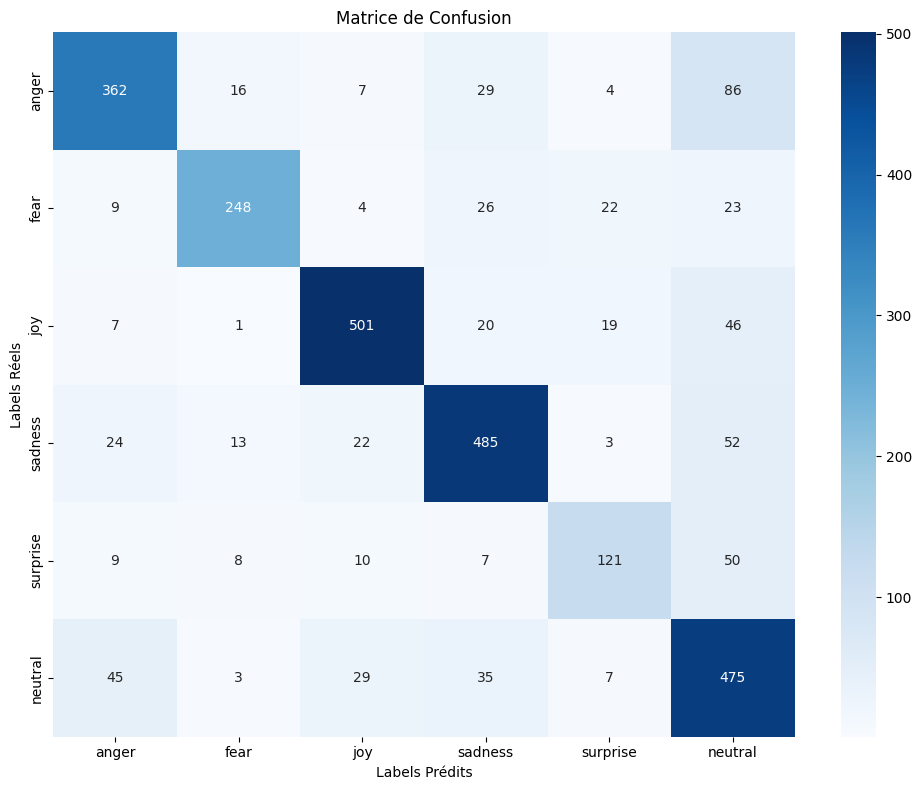

In [81]:
# Rapport de classification
print("\nRapport de Classification :")
print(classification_report(true_classes, predicted_classes, target_names=["anger", "fear", "joy", "sadness", "surprise", "neutral"]))

#rapport auc
auc_scores = {}
for i, label in enumerate(["anger", "fear", "joy", "sadness", "surprise", "neutral"]):
    auc_scores[label] = roc_auc_score(y_test.iloc[:, i], predictions[:, i])
print("AUC Scores:")
print(auc_scores)

# Matrice de confusion
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["anger", "fear", "joy", "sadness", "surprise", "neutral"], 
            yticklabels=["anger", "fear", "joy", "sadness", "surprise", "neutral"])
plt.xlabel('Labels Prédits')
plt.ylabel('Labels Réels')
plt.title('Matrice de Confusion')
plt.tight_layout()
plt.show()

#### &nbsp;&nbsp;f) courbes d'entrainement

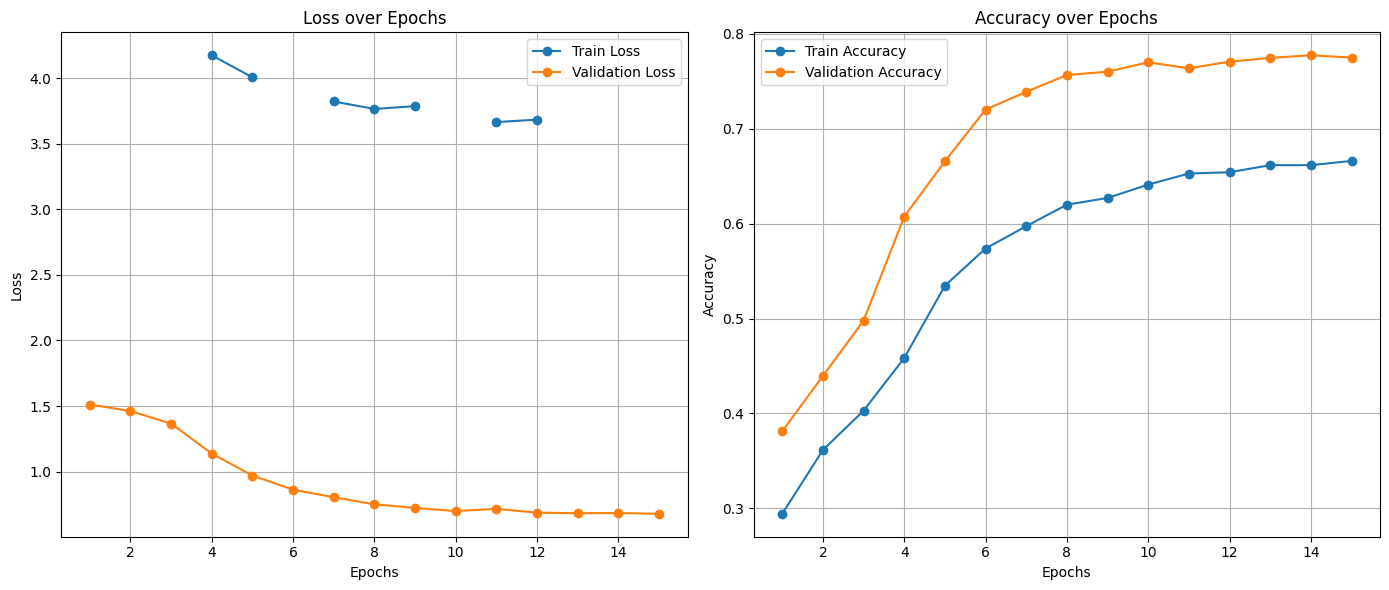

In [82]:
if history.history:
    # Extraction des métriques
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['categorical_accuracy']
    val_accuracy = history.history['val_categorical_accuracy']
    
    epochs_range = range(1, len(train_loss) + 1)

    # Création des graphiques
    plt.figure(figsize=(14, 6))

    # Graphique pour la perte
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Graphique pour la précision
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracy, label='Train Accuracy', marker='o')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Afficher les graphiques
    plt.tight_layout()
    plt.show()


#### &nbsp;&nbsp;g) phrases de tests

In [83]:
custom_sentences = [
    "I'm absolutely thrilled with this amazing news!",
    "Everything seems hopeless right now.",
    "I can't stop feeling angry about what happened.",
    "I'm terrified of what might happen next.",
    "This is the most boring day ever.",
    "My heart is breaking into pieces.",
    "I'm so frustrated with this situation.",
    "I'm deeply worried about the future.",
    "Life is beautiful and full of joy today!",
    "Rage is consuming me entirely.",
    "This is the most exciting moment of my life!",
    "I feel empty and disconnected.",
    "Nothing could make me happier right now.",
    "What a peaceful and calming experience.",
    "Pure excitement is running through my veins!",
    "I'm overwhelmed with sadness and grief.",
    "Unexpectedly, I'm feeling quite content.",
    "This fear is paralyzing me.",
    "Feeling completely neutral about everything.",
    "I'm feeling completely indifferent."
]


# Prétraiter les custom_sentences
custom_sentences_seq = tokenizer.texts_to_sequences(custom_sentences)
custom_sentences_padded = pad_sequences(custom_sentences_seq, maxlen=max_len)

# Effectuer des prédictions
predictions = model.predict(custom_sentences_padded)

# Convertir les prédictions en classes (émotions)
predicted_classes = np.argmax(predictions, axis=1)

# Définir une liste des étiquettes des émotions
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise", "neutral"]

# Afficher les résultats des prédictions
print("Custom Sentence Emotion Predictions:")
print(emotion_labels)
for sentence, probs, pred_class in zip(custom_sentences, predictions, predicted_classes):
    print(f"Sentence: '{sentence}'\nPredicted Emotion: {emotion_labels[pred_class]}\nProbabilities: {probs}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Custom Sentence Emotion Predictions:
['anger', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
Sentence: 'I'm absolutely thrilled with this amazing news!'
Predicted Emotion: surprise
Probabilities: [0.00877199 0.01104994 0.14207187 0.00345154 0.77332044 0.06133429]

Sentence: 'Everything seems hopeless right now.'
Predicted Emotion: sadness
Probabilities: [0.00933751 0.02548625 0.01902231 0.89033175 0.00651686 0.04930532]

Sentence: 'I can't stop feeling angry about what happened.'
Predicted Emotion: anger
Probabilities: [9.7018147e-01 9.9409409e-03 4.7453868e-04 1.1406223e-02 1.9675293e-03
 6.0293414e-03]

Sentence: 'I'm terrified of what might happen next.'
Predicted Emotion: fear
Probabilities: [0.0621866  0.6992776  0.00485122 0.04866919 0.08445249 0.10056287]

Sentence: 'This is the most boring day ever.'
Predicted Emotion: sadness
Probabilities: [0.07441624 0.07347531 0.07710148 0.4044098  0.03058225 0.34001485]

Sentence: 'My heart is break